In [1]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size': 22})

from tqdm import tqdm
from functools import partial

from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import Compose, ToTensor
from torchsummary import summary

from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

from wiener_loss import WienerLoss
from generative.networks.nets import AutoencoderKL

# from utils import *
# from landscape import LossLandscapeVisualisation

# Set seed, clear cache and enable anomaly detection (for debugging)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)

data_path = "/home/dp4018/data"

/home/dp4018/miniconda3/envs/monai/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
import random
import numpy as np
import torch


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any
    randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True

    return True


def set_device(device="cpu", idx=0):
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU"
                  "{} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device = "cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on"
                  "GPU 0 {}!".format(torch.cuda.device_count(),
                                     torch.cuda.get_device_name()))
            device = "cuda:0"
        else:
            device = "cpu"
            print("No GPU available! Running on CPU")
    return device


def get_params_to_update(model):
    """ Returns list of model parameters that have required_grad=True"""
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            params_to_update.append(param)
    return params_to_update


def print_single_stats(key, val):
    print(" %-45s %-15s %15s" % (key, ":", val))
    return None

def kl_div(mu, sigma):
    kl_loss = 0.5 * torch.sum(mu.pow(2) + sigma.pow(2) - torch.log(sigma.pow(2)) - 1, dim=[1, 2, 3])
    return torch.sum(kl_loss) / kl_loss.shape[0]


set_seed(42)
DEVICE = set_device("cuda", 0)

Cuda installed! Running on GPU0 NVIDIA GeForce RTX 2080 Ti!


/home/dp4018/miniconda3/envs/monai/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Training images: 10000 	 Validation Images: 800


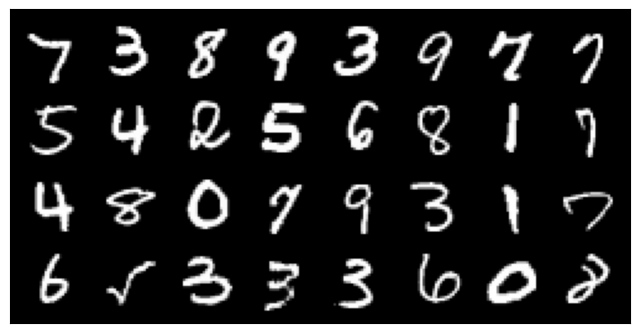

torch.Size([32, 1, 28, 28]) 0.0 1.0


In [3]:
batch_size=256    
valid_ratio = 0.2

dataset = MNIST(data_path, train=True, transform=Compose([ToTensor()]))

# Train / validation split
idxs = np.arange(0, len(dataset), 1)
i = int(len(dataset)*valid_ratio)
np.random.seed(42)
np.random.shuffle(idxs)
train_idxs, valid_idxs = idxs[:-i], idxs[-i:]
# train_idxs, valid_idxs = [0], [0]
train_idxs, valid_idxs = train_idxs[:10000], valid_idxs[:800]
train_dataset, valid_dataset = Subset(dataset, train_idxs), Subset(dataset, valid_idxs)
print("Training images: {} \t Validation Images: {}".format(len(train_dataset), len(valid_dataset)))

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Visualise batch
sample_batch = next(iter(train_loader))[0][:32]
plt.figure(figsize=(8,8))
plt.imshow(np.transpose(make_grid(sample_batch, pad_value=0, padding=3).numpy(),(1,2,0)))
plt.xticks([]); plt.yticks([])
plt.show()

print(sample_batch.shape, sample_batch.min().item(), sample_batch.max().item())

In [4]:
def instance_model():
    set_seed(42)
    return AutoencoderKL(
            spatial_dims=2,
            in_channels=sample_batch.shape[1],
            out_channels=sample_batch.shape[1],
            num_res_blocks=2,
            num_channels=(16, 32, 32),
            attention_levels=(False, False, False),
            latent_channels=sample_batch.shape[1],
            norm_num_groups=16,
        ).to(DEVICE)
    
def instance_optimiser(model, **kwargs):
    return torch.optim.NAdam(model.parameters(), **kwargs)

In [5]:
def train(model, optimiser, train_loader, criterion, num_epochs, log_freq=0, criterion_kwargs={}):
    model.train()
    device = next(iter(model.parameters())).device
    recon_atol = 1e-4
    
    train_losses = []
    train_filters = []
    train_recons = []
    train_inputs = []
    
    for epoch in tqdm(range(num_epochs)):
        for x, _ in train_loader:
            x = x.float().to(device)
            # with torch.amp.autocast(DEVICE[:4]):
            recon, mu, sigma = model(x)
            recon = torch.clamp(recon, -recon_atol, 1 + recon_atol)
            
            loss = criterion(x, recon, **criterion_kwargs)
            kl_loss = kl_div(mu, sigma)
            loss = loss + 1e-4*kl_loss
            
            train_losses.append(loss.item())
                
            loss.backward()
            optimiser.step()
            optimiser.zero_grad()
        
        if "filters" in criterion.__dict__:    
            train_filters.append(criterion.filters.detach().cpu())
        train_recons.append(recon.detach().cpu().numpy())
        train_inputs.append(x.detach().cpu().numpy())
        
        if (log_freq > 0 and epoch % log_freq == 0) or epoch == num_epochs - 1:
            print(f"================= Epoch {epoch+1}/{num_epochs} =================")
            plt.imshow(np.transpose(make_grid(x[:32].float(), pad_value=0, padding=3).detach().cpu().numpy(),(1,2,0))); plt.show()
            plt.imshow(np.transpose(make_grid(recon[:32].float(), pad_value=0, padding=3).detach().cpu().numpy(),(1,2,0))); plt.show()
            if "filters" in criterion.__dict__:
                for filter in criterion.filters:
                    plt.plot(filter.flatten().detach().cpu(), "-k", alpha=0.4)
                plt.plot(criterion.W.detach().cpu().flatten(), "-r"); plt.show()
            plt.plot(train_losses); plt.show()
    return train_losses, train_filters, train_recons, train_inputs

In [6]:
def scale2range(x, range=[-1, 1]):
    return (x - x.min()) * (max(range) - min(range)) / (x.max() - x.min()) + min(range)

def laplace2D(mesh, alpha=-0.2, beta=1.5):
    """ Helper function for AWLoss """
    xx, yy = mesh[:,:,0], mesh[:,:,1]
    x = torch.sqrt(xx**2 + yy**2) 
    T = 1 - torch.exp(-torch.abs(x) ** alpha) ** beta
    T = scale2range(T, [0.3, 1.])
    return T

def identity(mesh, val=1, **kwargs):
    xx, yy = mesh[:,:,0], mesh[:,:,1]
    T = torch.zeros_like(xx) + val
    return T

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = make_axes_locatable(im.axes)
    width = axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("bottom", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=None, **kwargs)

def plot_penalty(n, penalty_fn, eta=0, save_path=None, label=None, **kwargs):
    mesh = torch.meshgrid(torch.linspace(-1, 1, n), torch.linspace(-1, 1, n))
    mesh = torch.stack(mesh, axis=-1)
    penalty_ = penalty_fn(mesh, **kwargs)
    penalty = torch.diag(penalty_[n//2].view(n,))
    
    ticks = [0, (n-1)//2, n-1]
    lags = [i - (n-1)//2 for i in ticks]

    fig,axs = plt.subplots(ncols=4, figsize=(24,5))
    axs[0].imshow(penalty_ + eta *np.random.randn(n, n), cmap="plasma", vmin=0, vmax=1)
    axs[0].set_title(r"$\text{Penalty}$")
    
    im = axs[1].imshow(penalty + eta *np.random.randn(n, n), cmap="plasma", vmin=0, vmax=1)
    axs[1].set_title(r"$\mathbf{W}$")
    inv = np.linalg.inv(penalty.T @ penalty)
    
    axs[2].imshow(inv , cmap="plasma")
    axs[2].set_title(r"$\boldsymbol{\Sigma} = (\mathbf{W}^T\mathbf{W})^{-1}$")
    
    axs[3].plot(torch.diag(penalty).flatten())
    axs[3].set_title(r"$\text{Diag}(\mathbf{W})$")
    axs[3].set_ylim(-0.1, 1.1)
        
    for ax in axs[:-1]:
        ax.set_xticks(ticks, lags)
        ax.set_yticks(ticks, lags)
        ax.set_xlabel("lag_x")
    axs[3].set_xticks(ticks, lags)
    axs[3].set_xlabel("lag_x")
    axs[3].set_yticks([0., 1.])
        
    if label is not None:
        axs[0].set_ylabel(label + "\n\nlag_y", fontsize=28)
        
    plt.subplots_adjust(hspace=4)
    
    cbar_ax = fig.add_axes([0.13, -0.1, .075, 0.05])
    fig.colorbar(im, cax=cbar_ax, location="bottom", ticks=[0, 1.], orientation="horizontal")
    
    if save_path is not None:
        print("HELLO")
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    

  0%|          | 0/10 [00:00<?, ?it/s]

================= Epoch 1/10 =================


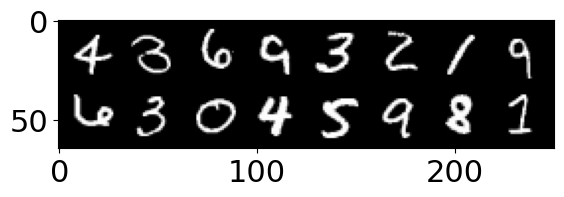

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


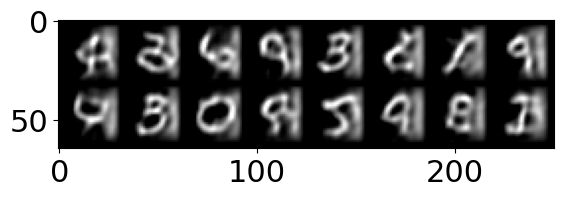

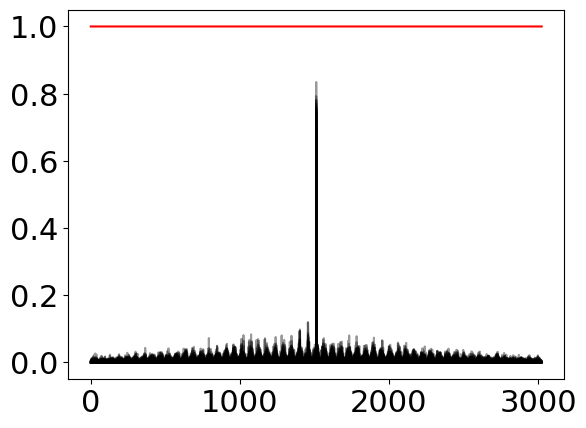

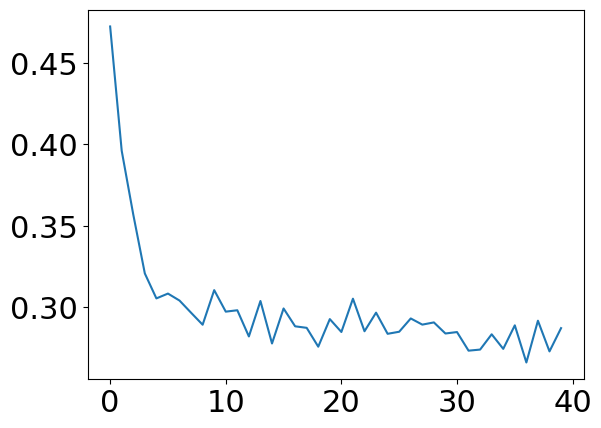

 50%|█████     | 5/10 [00:31<00:30,  6.14s/it]

================= Epoch 6/10 =================


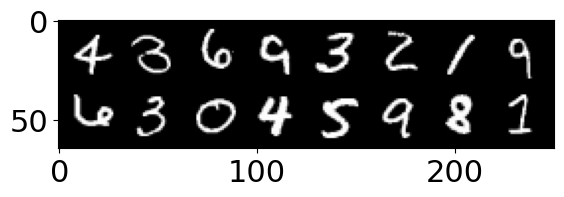

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


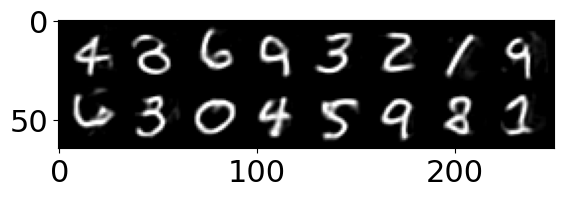

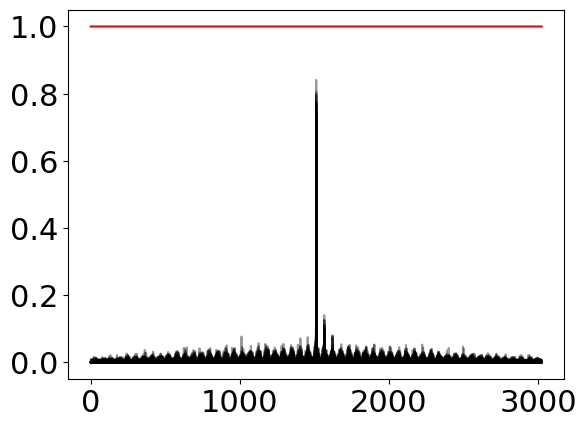

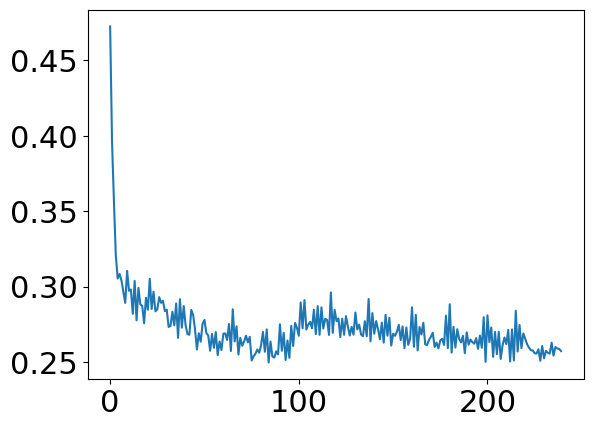

 90%|█████████ | 9/10 [00:56<00:06,  6.22s/it]

================= Epoch 10/10 =================


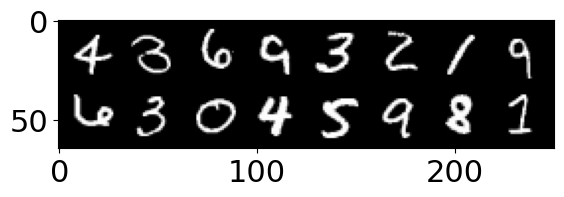

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


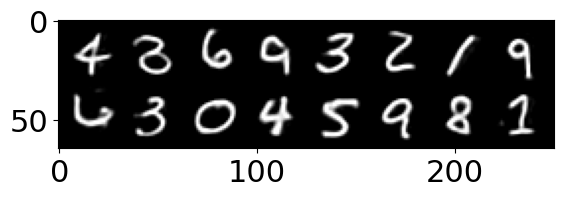

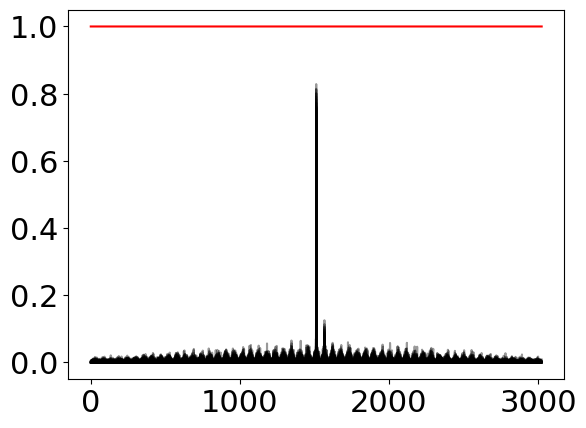

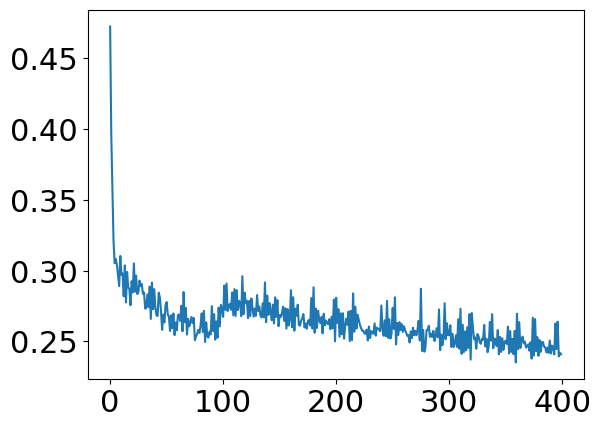

100%|██████████| 10/10 [01:03<00:00,  6.34s/it]


In [7]:
penalty_fn = identity
gamma = 0.25
epsilon = 5e-3 #7.
betas = (0.9, 0.999)
eta = 0.

lr = 1e-3
num_epochs=10

model_wl = instance_model()
optimiser_wl = torch.optim.NAdam(model_wl.parameters(), lr=lr, betas=betas)
awloss = WienerLoss(method="fft", filter_dim=2, filter_scale=2, mode="reverse", penalty_function=penalty_fn,
                    store_filters='unorm', clamp_min=0., epsilon=epsilon, rel_epsilon=True)

awloss_kwargs = dict(eta=eta, gamma=gamma)
losses_wl, filters_wl, recons_wl, inputs_wl = train(model_wl, optimiser_wl, train_loader, awloss, num_epochs, log_freq=5, criterion_kwargs=awloss_kwargs)

# landscape = LossLandscapeVisualisation(model_wl, valid_loader, awloss)
# landscape.compute(xmin=-1., xmax=1., ymin=-1., ymax=1., nx=10, ny=10, device=DEVICE)
# landscape.plot(mode="3d")

  0%|          | 0/10 [00:00<?, ?it/s]

================= Epoch 1/10 =================


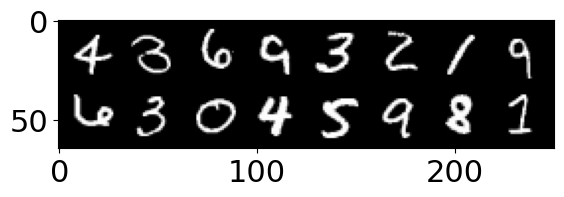

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


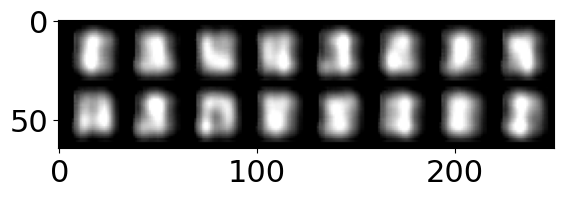

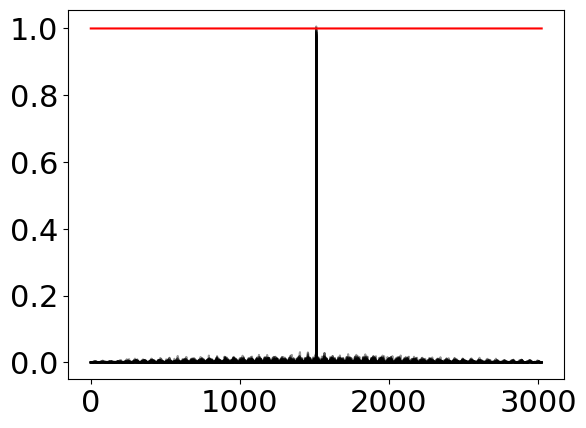

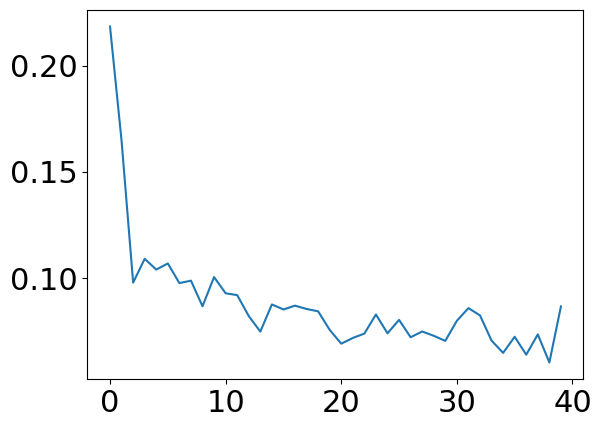

 50%|█████     | 5/10 [00:31<00:31,  6.31s/it]

================= Epoch 6/10 =================


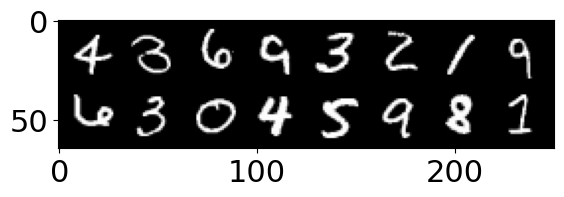

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


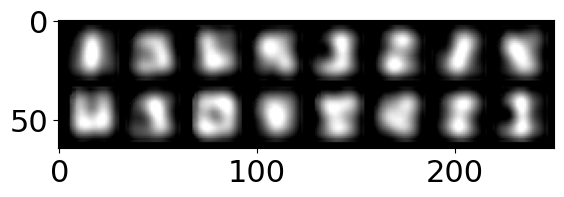

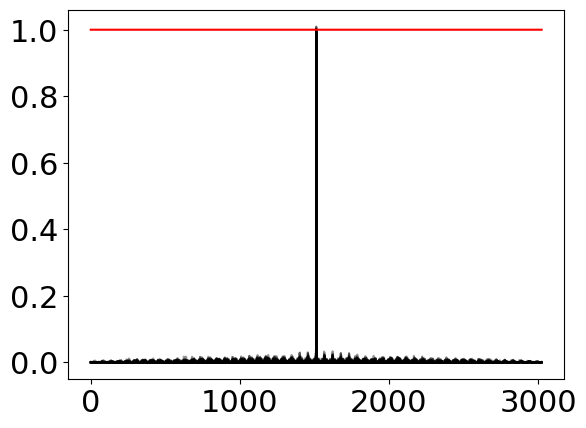

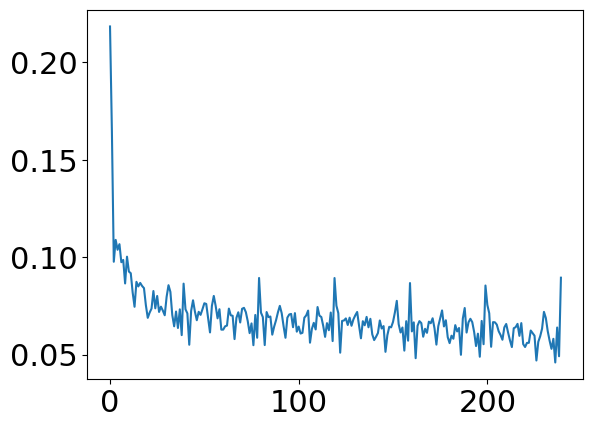

 90%|█████████ | 9/10 [00:57<00:06,  6.33s/it]

================= Epoch 10/10 =================


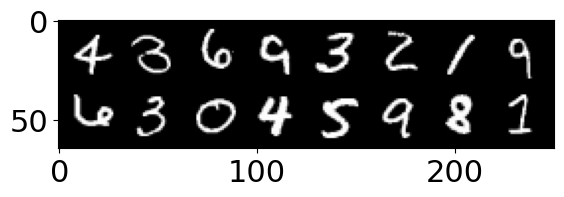

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


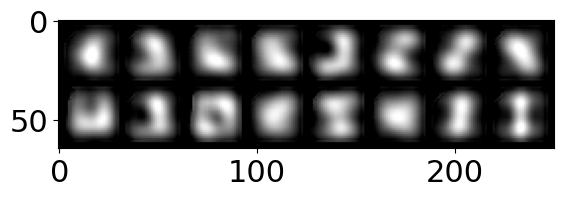

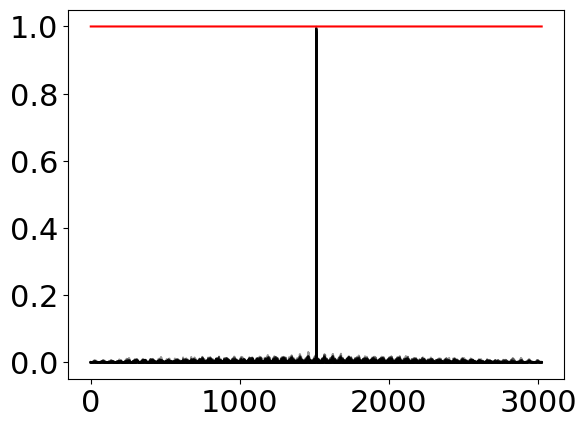

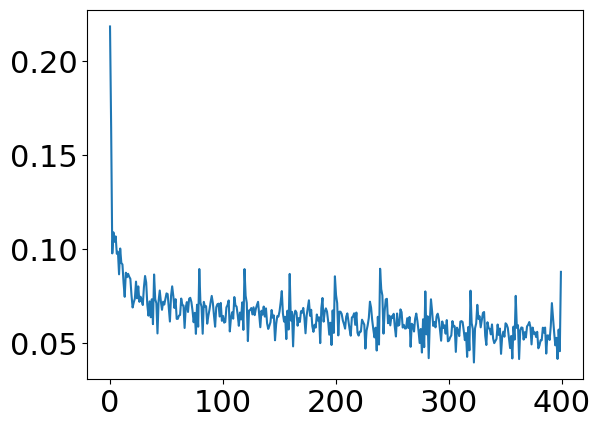

100%|██████████| 10/10 [01:04<00:00,  6.44s/it]


In [12]:
penalty_fn = identity
gamma = 0.25
epsilon = 1e-3
betas = (0.9, 0.999)
eta = 0.

lr = 1e-3
num_epochs=10

model_wl = instance_model()
optimiser_wl = torch.optim.NAdam(model_wl.parameters(), lr=lr, betas=betas)
awloss = WienerLoss(method="fft", filter_dim=2, filter_scale=2, mode="reverse", penalty_function=penalty_fn,
                    store_filters='unorm', clamp_min=0., epsilon=epsilon, corr_norm="minmax")

awloss_kwargs = dict(eta=eta, gamma=gamma)
losses_wl, filters_wl, recons_wl, inputs_wl = train(model_wl, optimiser_wl, train_loader, awloss, num_epochs, log_freq=5, criterion_kwargs=awloss_kwargs)

# landscape = LossLandscapeVisualisation(model_wl, valid_loader, awloss)
# landscape.compute(xmin=-1., xmax=1., ymin=-1., ymax=1., nx=10, ny=10, device=DEVICE)
# landscape.plot(mode="3d")

  0%|          | 0/10 [00:00<?, ?it/s]

================= Epoch 1/10 =================


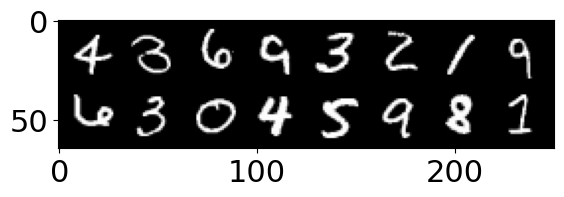

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


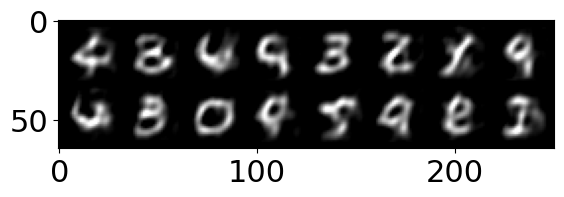

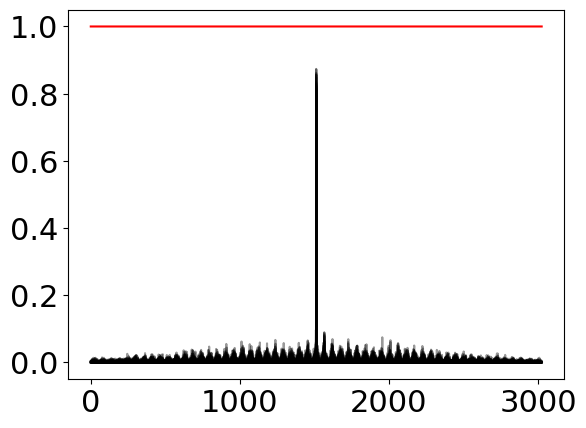

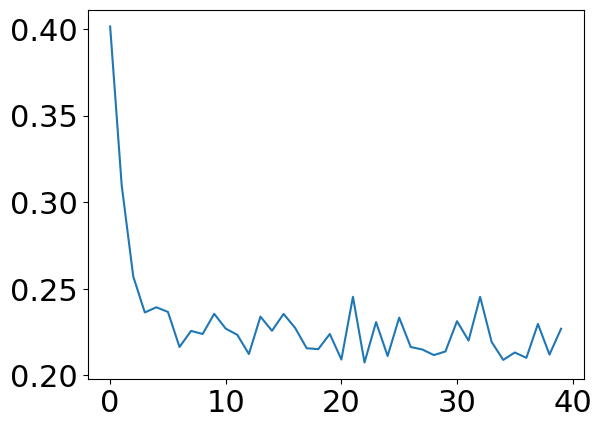

 50%|█████     | 5/10 [00:32<00:31,  6.30s/it]

================= Epoch 6/10 =================


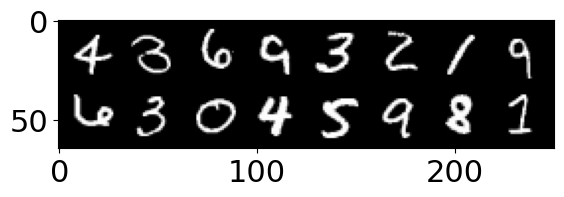

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


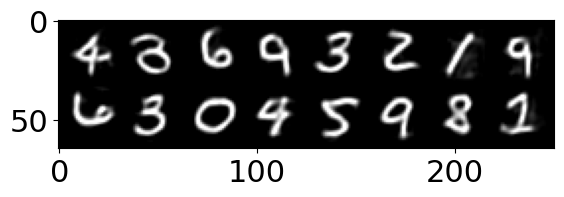

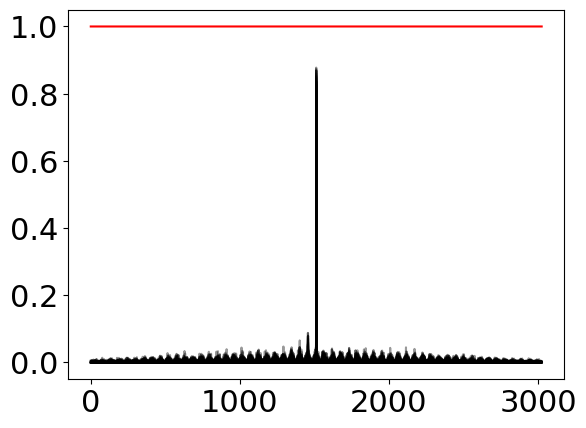

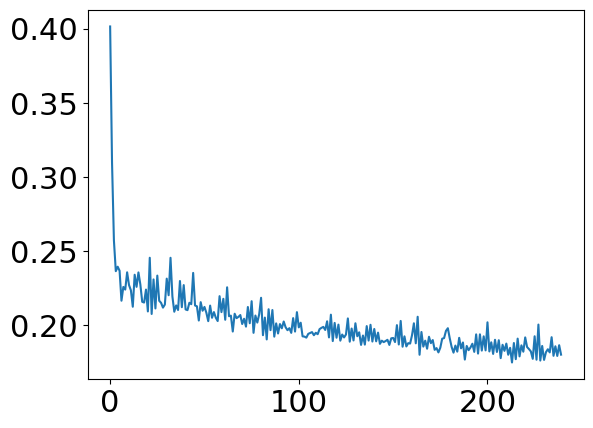

 90%|█████████ | 9/10 [00:57<00:06,  6.37s/it]

================= Epoch 10/10 =================


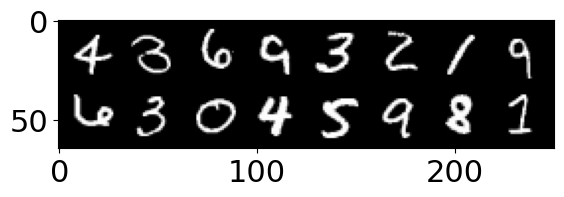

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


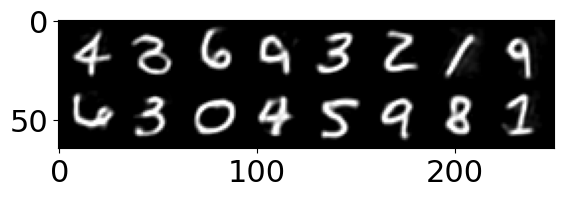

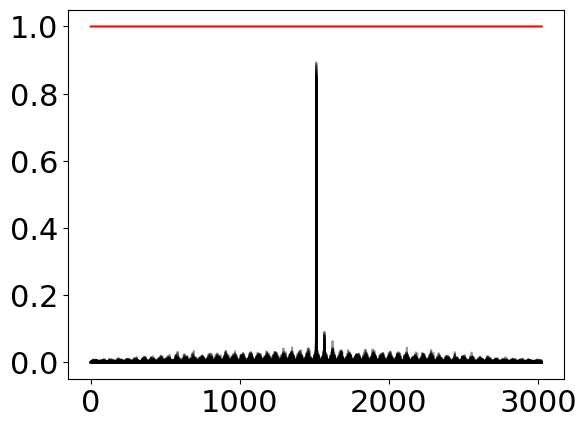

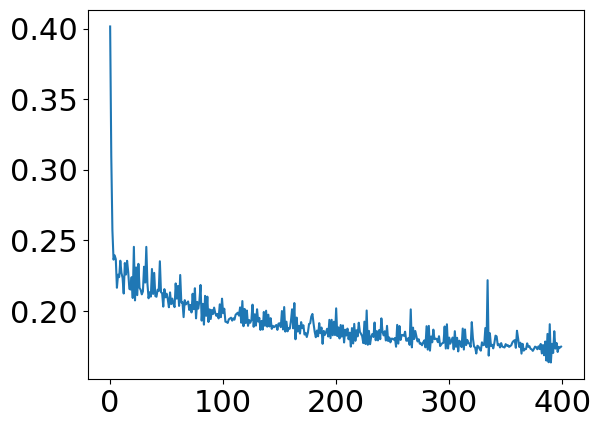

100%|██████████| 10/10 [01:04<00:00,  6.48s/it]


In [13]:
penalty_fn = identity
gamma = 0.25
epsilon = 1e-2
betas = (0.9, 0.999)
eta = 0.

lr = 1e-3
num_epochs=10

model_wl = instance_model()
optimiser_wl = torch.optim.NAdam(model_wl.parameters(), lr=lr, betas=betas)
awloss = WienerLoss(method="fft", filter_dim=2, filter_scale=2, mode="reverse", penalty_function=penalty_fn,
                    store_filters='unorm', clamp_min=0., epsilon=epsilon, corr_norm="rms", rel_epsilon=True)

awloss_kwargs = dict(eta=eta, gamma=gamma)
losses_wl, filters_wl, recons_wl, inputs_wl = train(model_wl, optimiser_wl, train_loader, awloss, num_epochs, log_freq=5, criterion_kwargs=awloss_kwargs)

# landscape = LossLandscapeVisualisation(model_wl, valid_loader, awloss)
# landscape.compute(xmin=-1., xmax=1., ymin=-1., ymax=1., nx=10, ny=10, device=DEVICE)
# landscape.plot(mode="3d")

  0%|          | 0/25 [00:00<?, ?it/s]

================= Epoch 1/25 =================


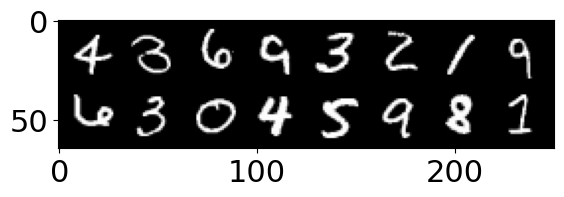

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


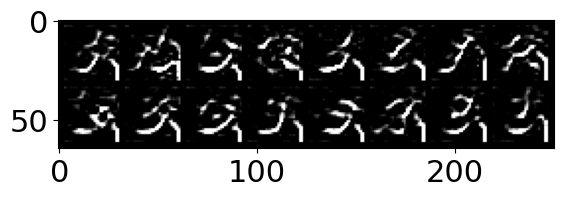

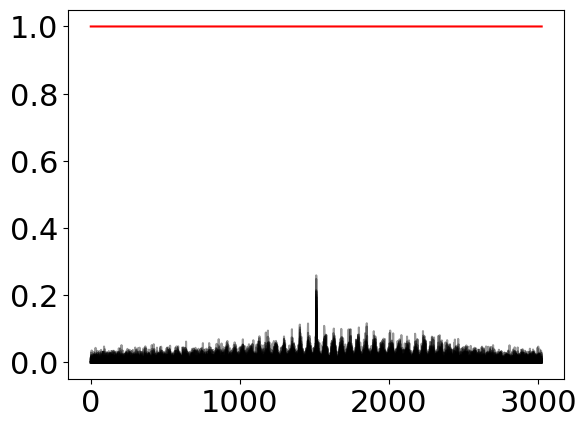

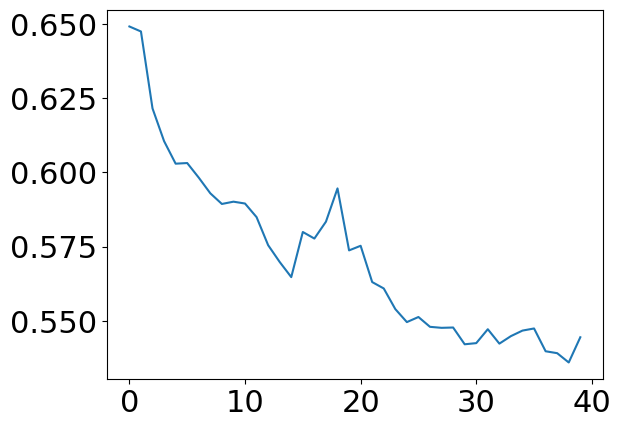

 20%|██        | 5/25 [00:32<02:06,  6.35s/it]

================= Epoch 6/25 =================


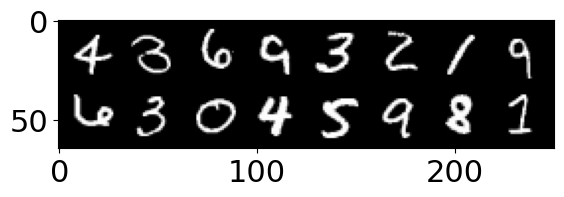

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


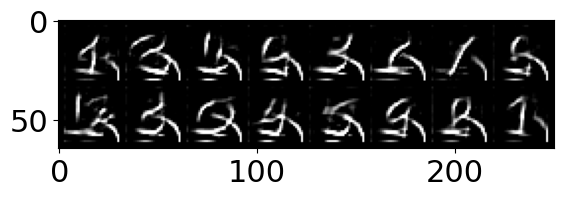

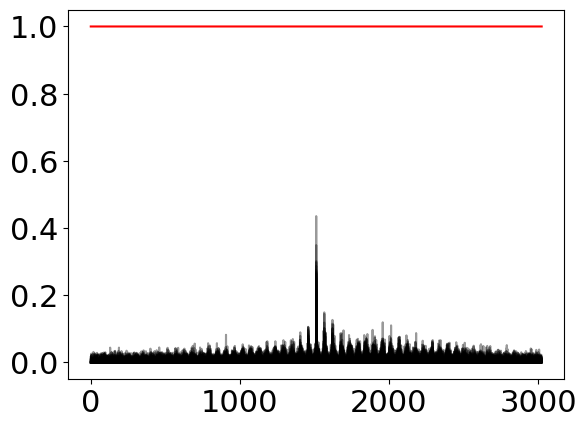

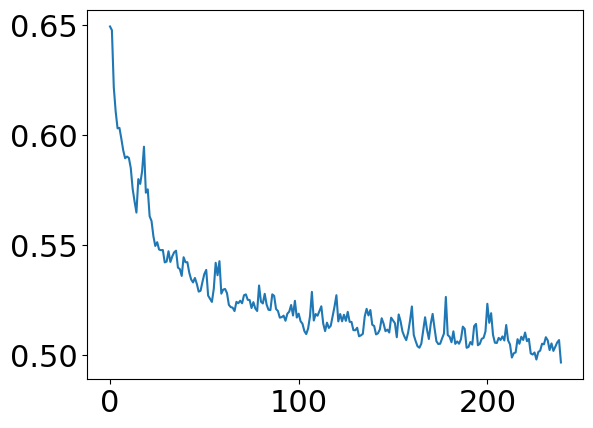

 40%|████      | 10/25 [01:03<01:32,  6.17s/it]

================= Epoch 11/25 =================


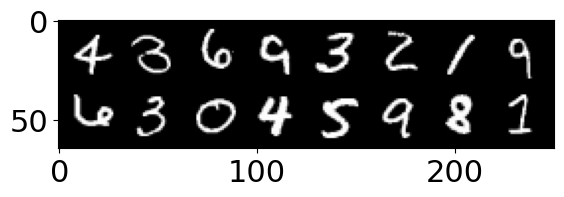

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


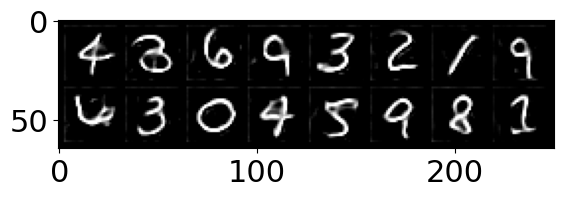

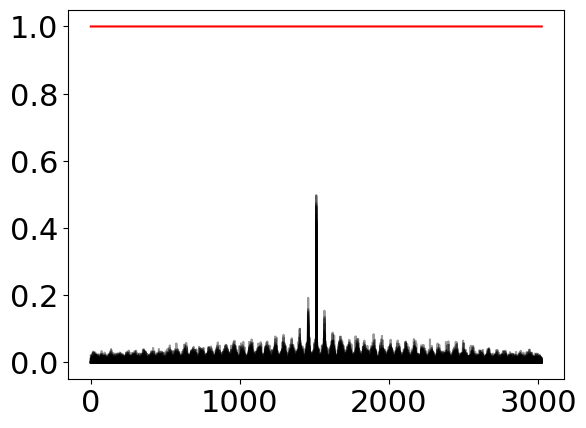

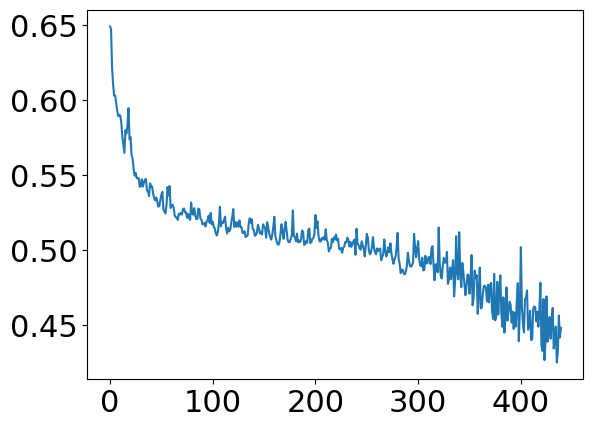

 60%|██████    | 15/25 [01:35<01:02,  6.27s/it]

================= Epoch 16/25 =================


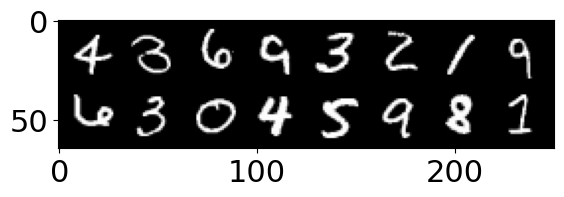

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


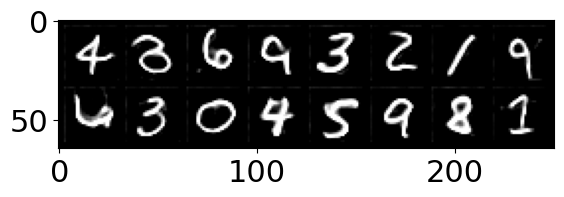

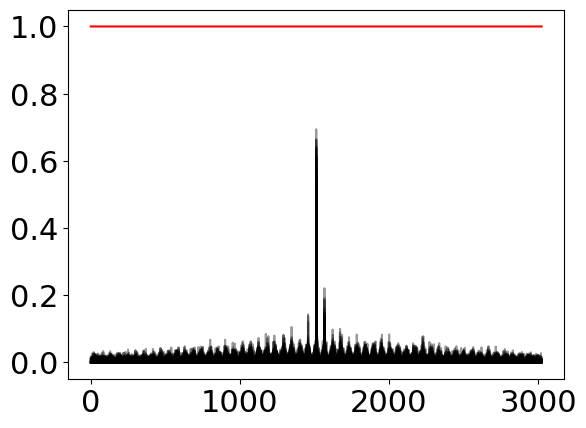

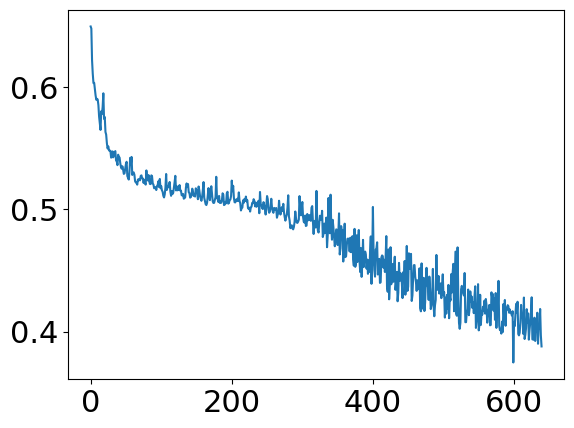

 80%|████████  | 20/25 [02:07<00:31,  6.32s/it]

================= Epoch 21/25 =================


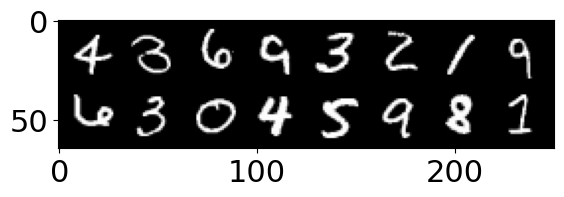

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


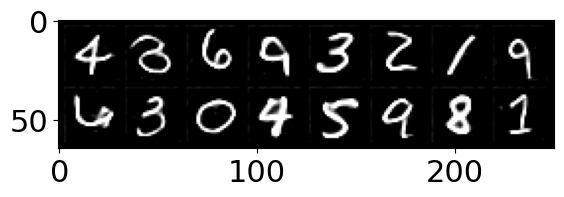

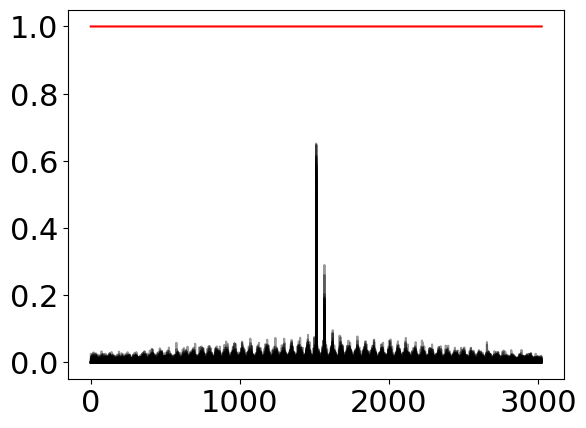

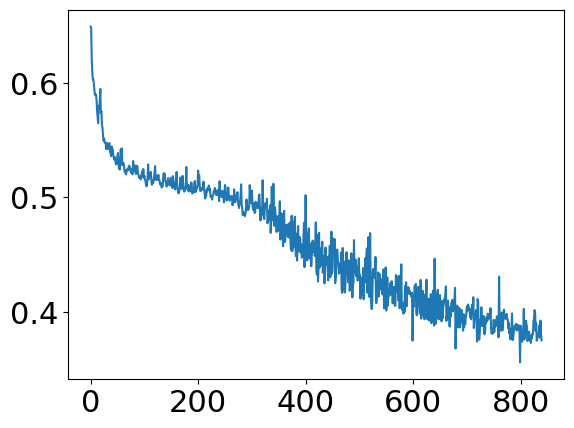

 96%|█████████▌| 24/25 [02:33<00:06,  6.32s/it]

================= Epoch 25/25 =================


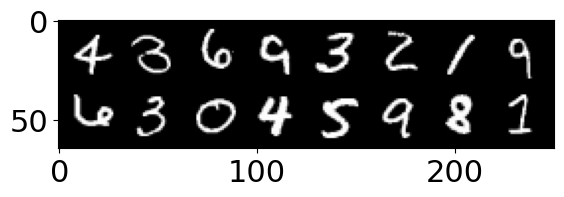

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


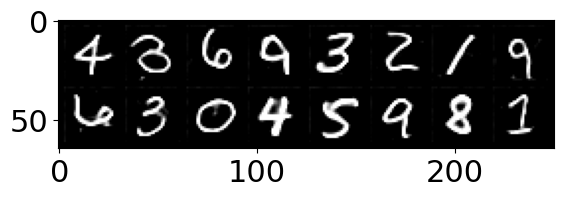

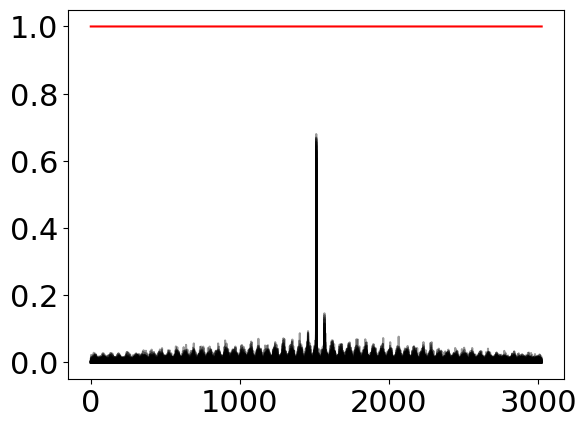

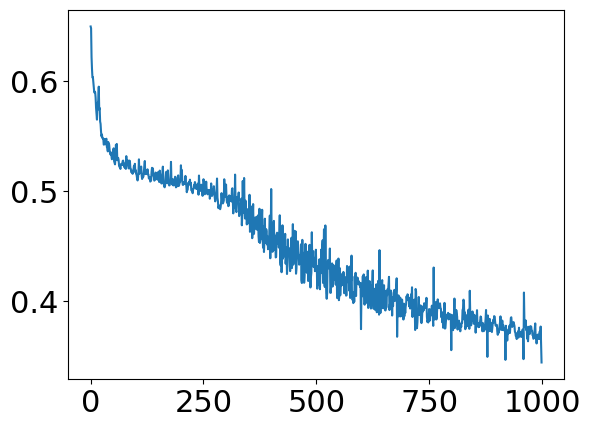

100%|██████████| 25/25 [02:40<00:00,  6.42s/it]


In [19]:
penalty_fn = identity
gamma = 0.2
epsilon = 1e-3
betas = (0.9, 0.999)
eta = 0.

lr = 1e-3
num_epochs=25

model_wl = instance_model()
optimiser_wl = torch.optim.NAdam(model_wl.parameters(), lr=lr, betas=betas)
awloss = WienerLoss(method="fft", filter_dim=2, filter_scale=2, mode="reverse", penalty_function=penalty_fn,
                    store_filters='unorm', clamp_min=0., epsilon=epsilon, corr_norm="ncc", rel_epsilon=False)

awloss_kwargs = dict(eta=eta, gamma=gamma)
losses_wl, filters_wl, recons_wl, inputs_wl = train(model_wl, optimiser_wl, train_loader, awloss, num_epochs, log_freq=5, criterion_kwargs=awloss_kwargs)

# landscape = LossLandscapeVisualisation(model_wl, valid_loader, awloss)
# landscape.compute(xmin=-1., xmax=1., ymin=-1., ymax=1., nx=10, ny=10, device=DEVICE)
# landscape.plot(mode="3d")